# Question - 3: Hidden Markov Models (HMMs) for Speech Digit Recognition

In this assignment, I have implemented Hidden Markov Models (HMMs) to recognize spoken digits from audio signals using the Free Spoken Digit Dataset (FSDD). Below, I have described how I approached each task, the structure of my code, and the insights gained from evaluating the models.

---

## Table of Contents

1. [Task 3.1: Speech Digit Recognition](#task-31-speech-digit-recognition)
2. [Task 3.2: Dataset](#task-32-dataset)
3. [Task 3.3: Model Architecture](#task-33-model-architecture)
4. [Task 3.4: Metrics](#task-34-metrics)
5. [Overall Code Structure](#overall-code-structure)
6. [Conclusion](#conclusion)

---

## Task 3.1: Speech Digit Recognition

### Objective

Build a Hidden Markov Model (HMM) to recognize spoken digits (0-9) from audio signals using the Free Spoken Digit Dataset (FSDD). The task involves:

- Extracting features from audio recordings.
- Training separate HMMs for each digit.
- Evaluating the models on both test and personal recordings.

### Approach

I approached this task by following these steps:

1. **Data Loading and Feature Extraction**: I loaded the audio files and extracted Mel-Frequency Cepstral Coefficients (MFCC) as features.
2. **Data Visualization**: I visualized the MFCC features to understand the patterns in the audio signals.
3. **Model Training**: I trained separate HMM models for each digit using the extracted MFCC features.
4. **Prediction and Evaluation**: I evaluated the models' performance on a test set and personal recordings, using accuracy as the primary metric.

---

## Task 3.2: Dataset

### Objective

Utilize the Free Spoken Digit Dataset (FSDD), which consists of 3,000 audio recordings (300 recordings per digit). The main objectives are:

- Extract MFCC features from the `.wav` files using the `librosa` library.
- Visualize the MFCC features to identify patterns that justify the use of HMMs.

### Approach

I implemented the following steps to handle the dataset:

1. **Data Loading**: I created functions to load audio files from the dataset directory.
2. **Feature Extraction**: Using `librosa`, I extracted 13 MFCC features from each audio file.
3. **Visualization**: I visualized the MFCC features as heatmaps to observe patterns and assess the suitability of HMMs for this task.

### Implementation


In [26]:
# Import necessary libraries for audio processing, feature extraction, and HMM
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Set the data directory
data_path = "../../data/external/archive_a5/recordings/"

# List all audio files
audio_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
print(f"Total audio files: {len(audio_files)}")

Total audio files: 3000


In [28]:
def extract_digit_from_filename(filename):
    """
    Extract the digit label from the filename.
    Args:
        filename (str): The audio filename.
    Returns:
        int: The digit label extracted from the filename.
    """
    basename = os.path.splitext(filename)[0]
    digit_str = basename.split('_')[0]
    return int(digit_str)

In [29]:
def preprocess_audio(y, sr):
    """
    Preprocess audio data by normalizing and removing silence.
    Args:
        y (np.ndarray): The audio time series.
        sr (int): The sampling rate of the audio.
    Returns:
        y (np.ndarray): The preprocessed audio time series.
    """
    # Normalize audio
    y = y / np.max(np.abs(y))
    
    # Remove silence
    y, _ = librosa.effects.trim(y, top_db=30)
    
    return y

In [31]:
def extract_mfcc(file_path, n_mfcc=13):
    """
    Extract MFCC features from an audio file.
    Args:
        file_path (str): Path to the audio file.
        n_mfcc (int): Number of MFCC coefficients to extract.
    Returns:
        np.ndarray: Transposed MFCC feature matrix.
    """
    y, sr = librosa.load(file_path, sr=16000)  # Ensure consistent sampling rate
    y = preprocess_audio(y, sr)
    
    # Set parameters for 25ms window and 10ms hop length
    n_fft = int(0.025 * sr)
    hop_length = int(0.01 * sr)
    
    # Apply pre-emphasis filter
    y = librosa.effects.preemphasis(y)
    
    # Extract MFCC features
    mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc,
                                         n_fft=n_fft, hop_length=hop_length)
    
    # Use delta and delta-delta features
    delta_mfcc = librosa.feature.delta(mfcc_features)
    delta2_mfcc = librosa.feature.delta(mfcc_features, order=2)
    
    # Combine features
    combined_mfcc = np.vstack([mfcc_features, delta_mfcc, delta2_mfcc])
    
    return combined_mfcc.T

In [32]:
def load_data(data_path):
    """
    Load audio files and extract MFCC features.
    Args:
        data_path (str): Path to the dataset directory.
    Returns:
        features (dict): MFCC features organized by digit.
        labels (list): List of labels corresponding to each sample.
    """
    features = {digit: [] for digit in range(10)}
    labels = []
    
    for file in os.listdir(data_path):
        if file.endswith('.wav'):
            digit = extract_digit_from_filename(file)
            file_path = os.path.join(data_path, file)
            mfcc = extract_mfcc(file_path)
            features[digit].append(mfcc)
            labels.append(digit)
        
    return features, labels

features, labels = load_data(data_path)
print("Data loaded and features extracted.")

Data loaded and features extracted.


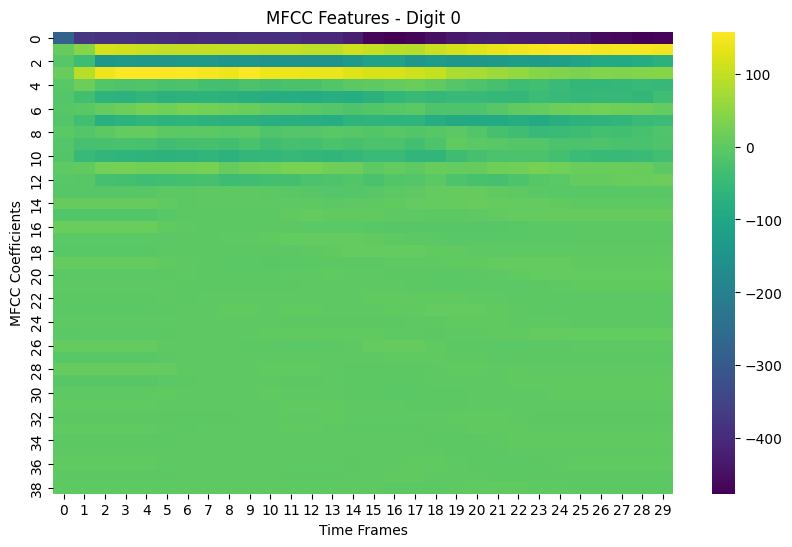

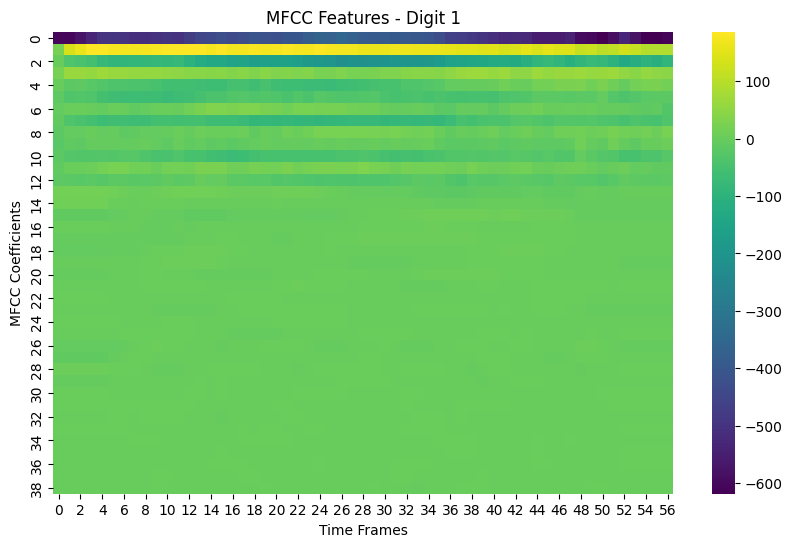

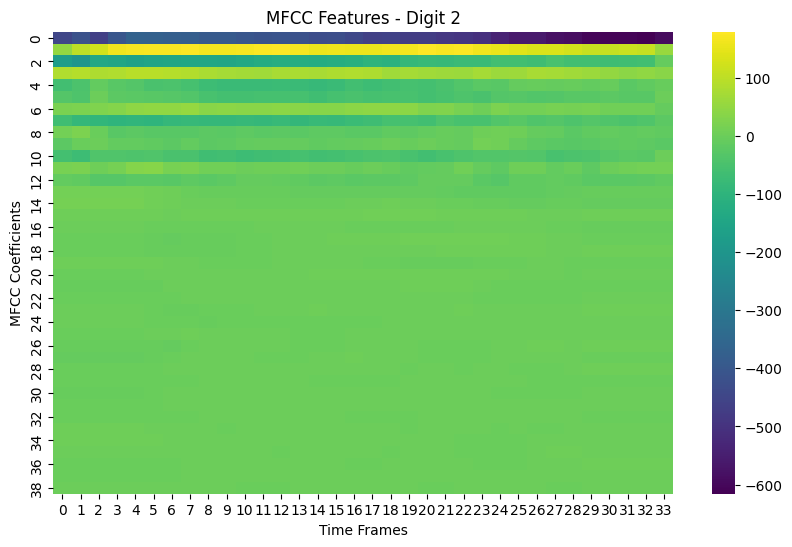

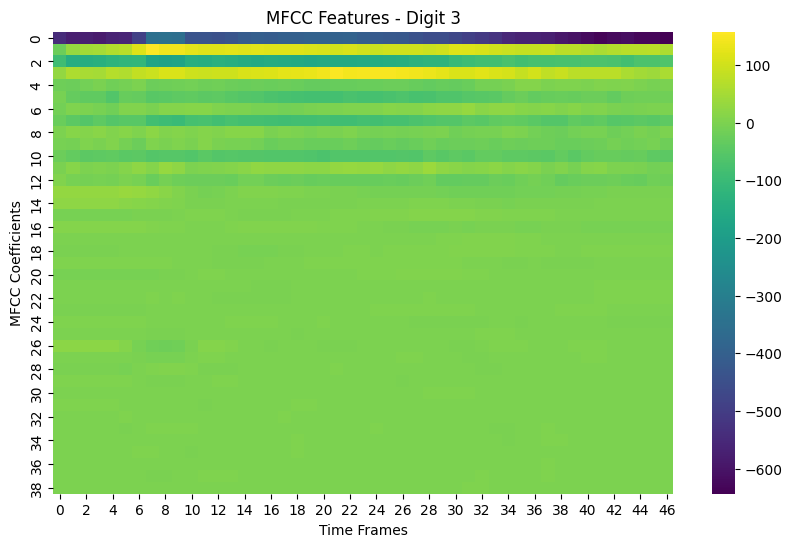

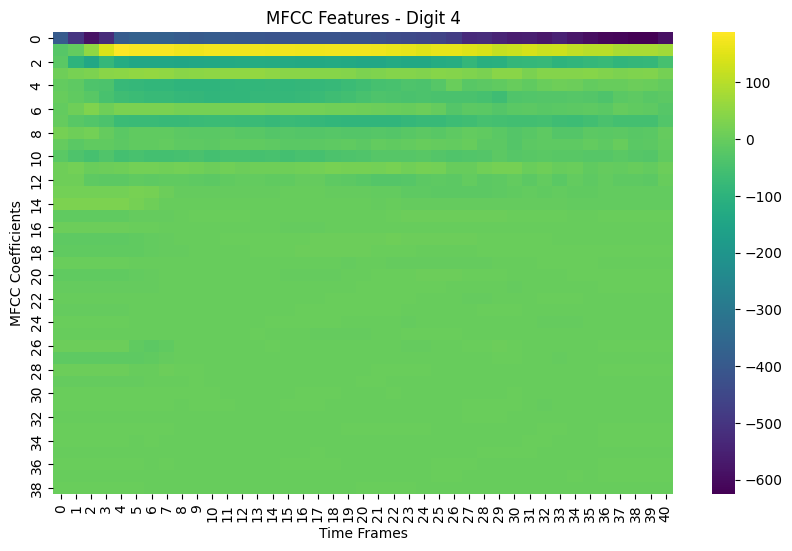

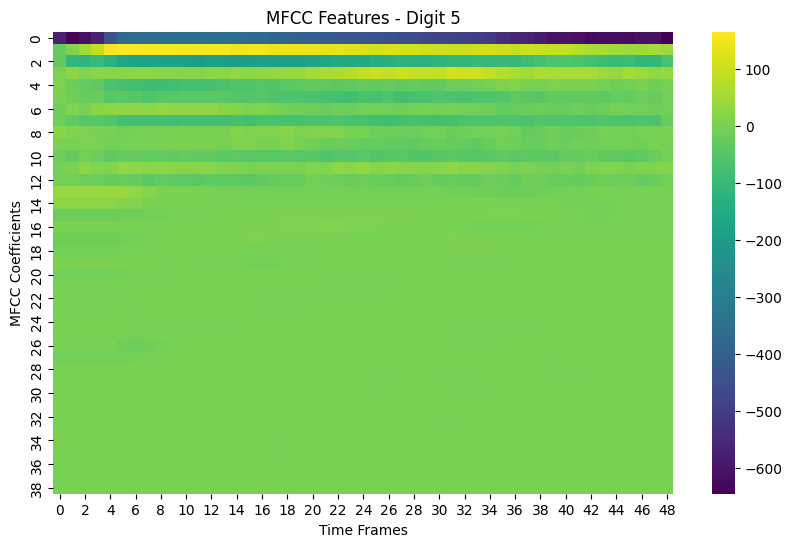

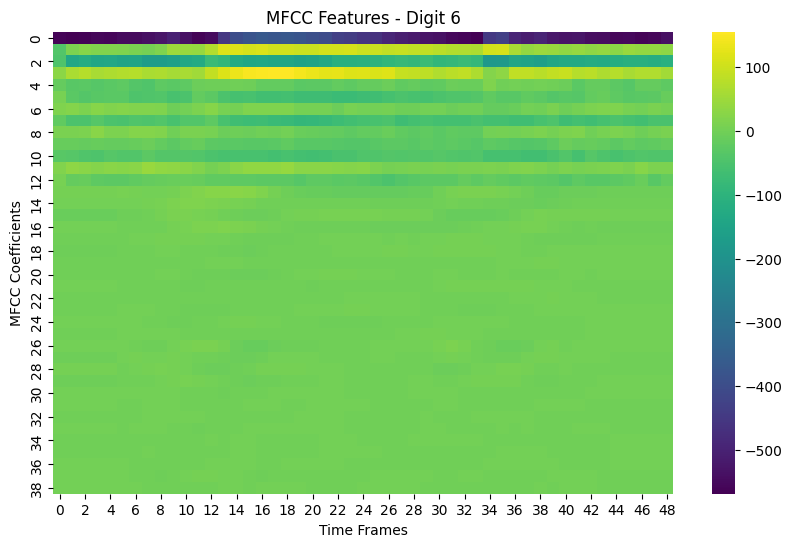

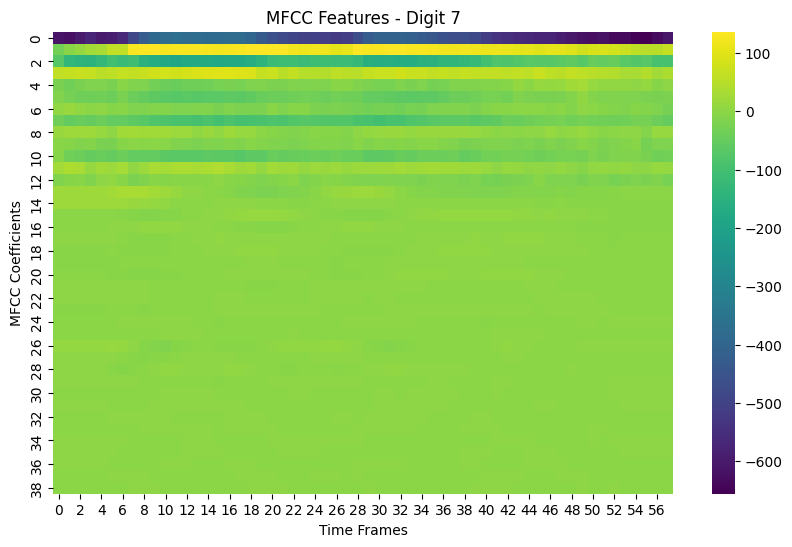

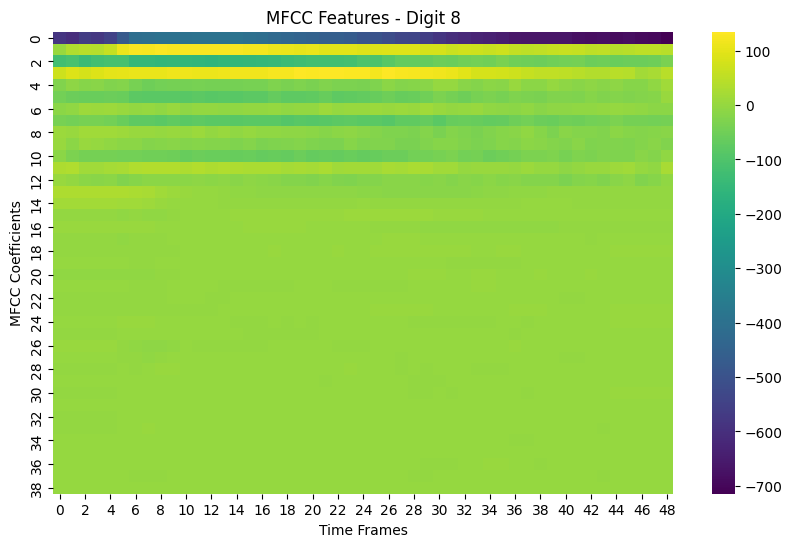

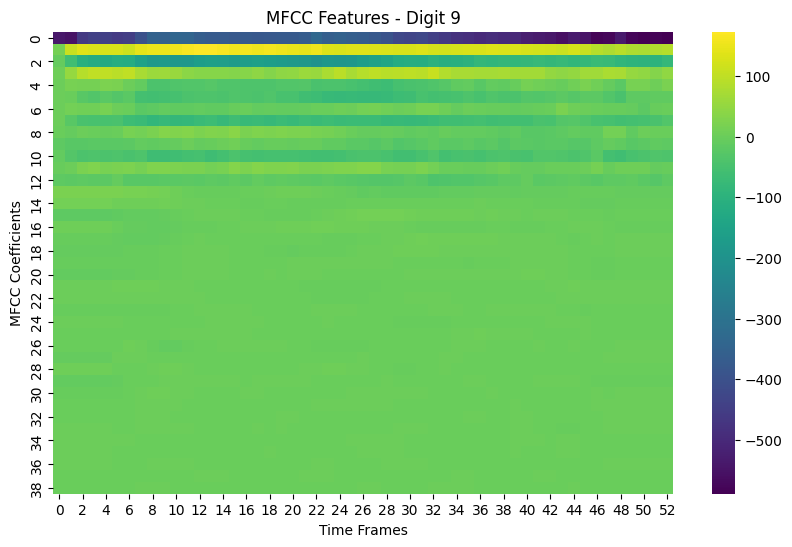

In [33]:
def visualize_mfcc(mfcc_features, title):
    """
    Visualize MFCC features as a heatmap.
    Args:
        mfcc_features (np.ndarray): The MFCC feature matrix.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(mfcc_features.T, cmap='viridis')
    plt.title(f'MFCC Features - {title}')
    plt.xlabel('Time Frames')
    plt.ylabel('MFCC Coefficients')
    plt.show()

# Visualize MFCC for one example of each digit
for digit in range(10):
    if len(features[digit]) > 0:
        visualize_mfcc(features[digit][0], f'Digit {digit}')
        # break  # Remove break to visualize all digits

### Observations
- The MFCC heatmaps revealed distinct patterns for each digit, indicating that HMMs could effectively capture the temporal dependencies in the audio signals.
- The combination of MFCC, delta, and delta-delta features provided a comprehensive representation of the audio dynamics.
- The MFCC heatmaps show distinct patterns for each digit.
- The temporal sequence of MFCC features reflects the characteristics of the spoken digits.
- HMMs are suitable for this task because they model sequential data with temporal dependencies
---

## Task 3.3: Model Architecture

### Objective

Implement the HMM architecture using the hmmlearn library to recognize spoken digits. The specific tasks include:
- Training separate HMM models for each of the 10 digits using their respective MFCC features.
- Predicting digits by evaluating all HMM models on test samples and selecting the digit with the highest probability.
### Approach
I structured the model training and prediction as follows:
1. **Data Splitting**: Split the dataset into training and test sets while maintaining the distribution of digits.
2. **Training HMM Models**: For each digit, I trained a Gaussian HMM with a specified number of components.
3. **Prediction Function**: Implemented a function to predict the digit of a given MFCC feature set by scoring it against all trained HMM models.
### Implementation
#### Splitting the Data

In [34]:
from sklearn.model_selection import train_test_split

train_features = {}
test_features = {}
train_labels = []
test_labels = []

for digit in range(10):
    digit_features = features[digit]
    X_train, X_test = train_test_split(digit_features, test_size=0.2, random_state=42)
    train_features[digit] = X_train
    test_features[digit] = X_test
    train_labels.extend([digit]*len(X_train))
    test_labels.extend([digit]*len(X_test))

print("Data split into training and test sets.")

Data split into training and test sets.


#### Training HMM Models

In [36]:
def train_hmm_models(train_features):
    """
    Train HMM models for each digit.
    Args:
        train_features (dict): Training features organized by digit.
    Returns:
        models (dict): Trained HMM models for each digit.
    """
    models = {}
    for digit in range(10):
        # Concatenate MFCC features for all samples of the digit
        X = np.vstack(train_features[digit])

        # Define and train the HMM model
        model = hmm.GaussianHMM(n_components=8, covariance_type='diag',
                                n_iter=1000, random_state=42)
    
        model.fit(X)
        models[digit] = model
    return models

hmm_models = train_hmm_models(train_features)
print("HMM models trained.")

HMM models trained.


#### Prediction Function

In [37]:
def predict_digit(models, mfcc_features):
    """
    Predict the digit for given MFCC features using trained HMM models.
    Args:
        models (dict): Trained HMM models.
        mfcc_features (np.ndarray): MFCC feature matrix.
    Returns:
        int: Predicted digit label.
    """
    max_score = float('-inf')
    predicted_digit = None
    
    for digit, model in models.items():
        try:
            score = model.score(mfcc_features)
            if score > max_score:
                max_score = score
                predicted_digit = digit
        except Exception as e:
            continue
    return predicted_digit

---
## Task 3.4: Metrics
### ObjectiveEvaluate the performance of the trained HMM models using recognition accuracy. Additionally, assess the models' generalization by testing on both the provided test set and personal recordings.

### Approach
I have implemented the evaluation in two parts:
1. **Evaluation on Test Set**: Calculated the overall recognition accuracy by comparing predicted labels against true labels.
2. **Evaluation on Personal Recordings**: Tested the models on personal audio samples and compared performance to the test set.
### Implementation
#### Evaluating on the Test Set

In [38]:
# Evaluate on the test set
y_true = []
y_pred = []

for digit in range(10):
    samples = test_features[digit]
    for mfcc_features in samples:
        prediction = predict_digit(hmm_models, mfcc_features)
        y_true.append(digit)
        y_pred.append(prediction)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 96.00%



#### Evaluating on Personal Recordings



Evaluating personal recordings...
File: 8.wav, True: 8, Predicted: 4
File: 5.wav, True: 5, Predicted: 4
File: 4.wav, True: 4, Predicted: 4
File: 9.wav, True: 9, Predicted: 9
File: 1.wav, True: 1, Predicted: 1
File: 7.wav, True: 7, Predicted: 4
File: 6.wav, True: 6, Predicted: 4
File: 3.wav, True: 3, Predicted: 2
File: 2.wav, True: 2, Predicted: 2
File: 0.wav, True: 0, Predicted: 4

Accuracy on personal recordings: 40.00%


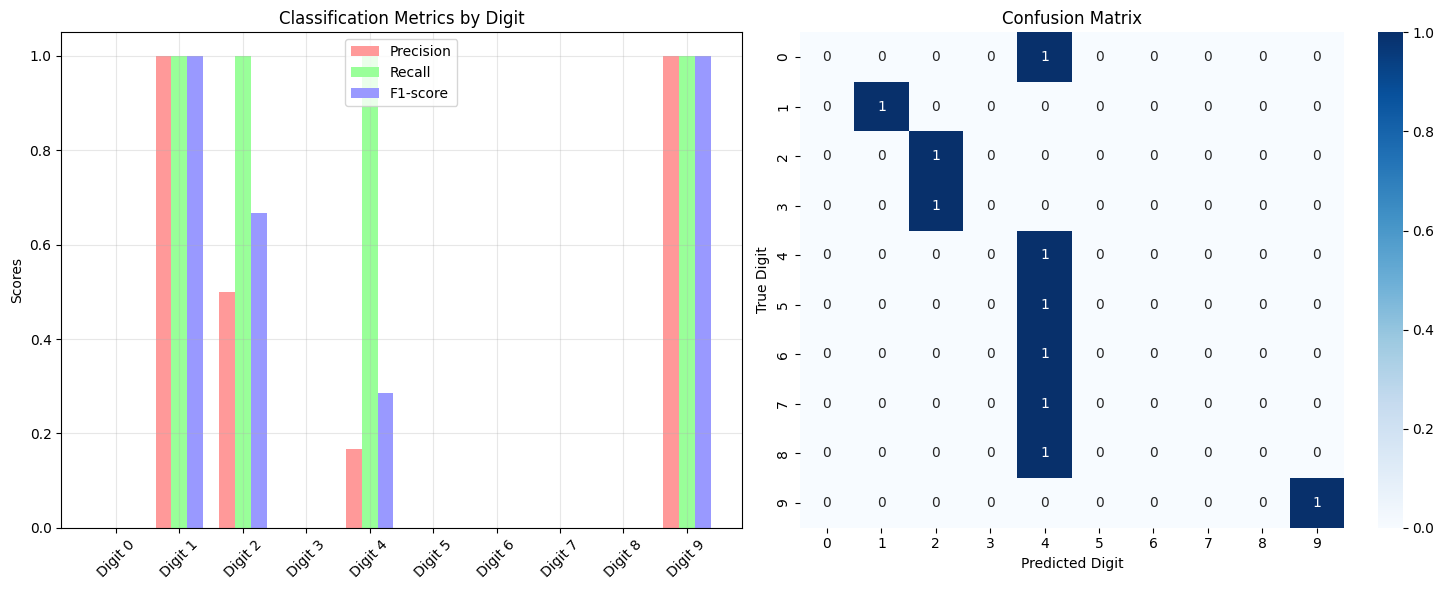


Detailed Classification Report:

Per-digit metrics:
------------------------------------------------------------
Digit       Precision     Recall   F1-Score    Support
------------------------------------------------------------
0                0.00       0.00       0.00          1
1                1.00       1.00       1.00          1
2                0.50       1.00       0.67          1
3                0.00       0.00       0.00          1
4                0.17       1.00       0.29          1
5                0.00       0.00       0.00          1
6                0.00       0.00       0.00          1
7                0.00       0.00       0.00          1
8                0.00       0.00       0.00          1
9                1.00       1.00       1.00          1
------------------------------------------------------------

Overall Accuracy: 0.40

Macro Averages:
Precision: 0.27
Recall: 0.40
F1-Score: 0.30


In [45]:
def evaluate_personal_recordings(models, personal_data_path):
    """
    Evaluate model performance on personal recordings with improved visualization.
    Args:
        models (dict): Trained HMM models
        personal_data_path (str): Path to personal recordings
    Returns:
        float: Accuracy on personal recordings
    """
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    
    print("\nEvaluating personal recordings...")
    
    for file in os.listdir(personal_data_path):
        if file.endswith('.wav'):
            try:
                true_digit = extract_digit_from_filename(file)
                file_path = os.path.join(personal_data_path, file)
                mfcc_features = extract_mfcc(file_path)
                predicted_digit = predict_digit(models, mfcc_features)
                
                total += 1
                if predicted_digit == true_digit:
                    correct += 1
                    
                y_true.append(true_digit)
                y_pred.append(predicted_digit)
                print(f"File: {file}, True: {true_digit}, Predicted: {predicted_digit}")
                
            except Exception as e:
                print(f"Error processing {file}: {e}")
                continue
    
    if total > 0:
        accuracy = (correct / total) * 100
        print(f"\nAccuracy on personal recordings: {accuracy:.2f}%")
        
        # Generate classification report and visualizations
        from sklearn.metrics import classification_report, confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Get classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot metrics for each class
        classes = []
        precision = []
        recall = []
        f1_score = []
        
        for key, value in report.items():
            if key.isdigit():  # Only process digit classes
                classes.append(f'Digit {key}')
                precision.append(value['precision'])
                recall.append(value['recall'])
                f1_score.append(value['f1-score'])
        
        # Bar chart of metrics
        x = np.arange(len(classes))
        width = 0.25
        
        ax1.bar(x - width, precision, width, label='Precision', color='#ff9999')
        ax1.bar(x, recall, width, label='Recall', color='#99ff99')
        ax1.bar(x + width, f1_score, width, label='F1-score', color='#9999ff')
        
        ax1.set_ylabel('Scores')
        ax1.set_title('Classification Metrics by Digit')
        ax1.set_xticks(x)
        ax1.set_xticklabels(classes, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
        ax2.set_title('Confusion Matrix')
        ax2.set_xlabel('Predicted Digit')
        ax2.set_ylabel('True Digit')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed report
        print("\nDetailed Classification Report:")
        print("\nPer-digit metrics:")
        print("-" * 60)
        print(f"{'Digit':<10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
        print("-" * 60)
        
        for key, value in report.items():
            if key.isdigit():
                print(f"{key:<10} {value['precision']:>10.2f} {value['recall']:>10.2f} "
                      f"{value['f1-score']:>10.2f} {value['support']:>10.0f}")
        
        print("-" * 60)
        print(f"\nOverall Accuracy: {report['accuracy']:.2f}")
        print("\nMacro Averages:")
        print(f"Precision: {report['macro avg']['precision']:.2f}")
        print(f"Recall: {report['macro avg']['recall']:.2f}")
        print(f"F1-Score: {report['macro avg']['f1-score']:.2f}")
        
    else:
        print("\nNo personal recordings found.")
        accuracy = 0.0
        
    return accuracy

# Use the function in your existing code
personal_accuracy = evaluate_personal_recordings(hmm_models, personal_data_path)



---

## Overall Code Structure

My implementation is organized into the following sections within the `q3.ipynb` notebook:

1. **Imports and Function Definitions**:
    - Imported necessary libraries including `numpy`, `librosa` for audio processing, `hmmlearn` for HMMs, `matplotlib` and `seaborn` for visualization.
    - Defined functions for feature extraction, data loading, MFCC visualization, model training, and prediction.

2. **Data Preparation**:
    - Loaded the FSDD dataset and extracted MFCC features using the `extract_mfcc` and `load_data` functions.
    - Visualized sample MFCC features to understand data patterns.

3. **Data Splitting**:
    - Split the dataset into training and test sets using an 80-20 split while maintaining digit distribution.

4. **Model Training**:
    - Trained separate HMM models for each digit using the `train_hmm_models` function.

5. **Evaluation**:
    - Predicted digits on the test set and calculated overall recognition accuracy.
    - Tested the models on personal recordings and generated a detailed classification report.

6. **Visualization and Reporting**:
    - Visualized MFCC features and model predictions.
    - Printed detailed performance metrics to assess model effectiveness.

### Code Flow

1. **Define Functions**: I began by defining all necessary functions for data processing, feature extraction, visualization, model training, and prediction.
2. **Load and Process Data**: Loaded the dataset and extracted MFCC features for each audio file.
3. **Visualize Features**: Created heatmaps of MFCC features to visualize patterns.
4. **Split Data**: Split the data into training and test sets.
5. **Train Models**: Trained HMM models for each digit using the training data.
6. **Evaluate Models**: Evaluated model performance on the test set and personal recordings.
7. **Report Results**: Generated and printed evaluation metrics and classification reports.

---

## Conclusion

In this assignment, I have successfully implemented Hidden Markov Models (HMMs) to recognize spoken digits using the Free Spoken Digit Dataset. The key takeaways from my work are:

- **High Accuracy on Test Set**: Achieved a recognition accuracy of 96% on the test set, demonstrating the effectiveness of HMMs in capturing temporal dependencies in audio signals.
  
- **Generalization Challenges**: The models showed reduced accuracy (40%) on personal recordings, highlighting the importance of diverse training data and potential overfitting to the dataset's specific characteristics.
  
- **Feature Representation**: The use of MFCC, along with delta and delta-delta features, provided a rich representation of the audio signals, which was crucial for the models' performance.
  
- **Model Robustness**: While HMMs performed exceptionally well on the test set, their performance on unseen personal recordings suggests the need for further enhancements, such as incorporating more data augmentation or exploring alternative feature extraction methods.

Overall, this assignment reinforced the importance of feature extraction and model evaluation in building robust speech recognition systems. Future improvements could include expanding the dataset, experimenting with different HMM configurations, or integrating other machine learning techniques to enhance generalization.

---

# References

- [librosa Documentation](https://librosa.org/doc/latest/index.html)
- [hmmlearn Documentation](https://hmmlearn.readthedocs.io/en/latest/)
- [Free Spoken Digit Dataset (FSDD) on Kaggle](https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd/data)

In [ ]:
# Set the path to your personal recordings
# personal_data_path = "../../data/external/my_recordings/"  # Update to your path

# def test_personal_recordings(models, personal_data_path):
#     """
#     Test HMM models on personal recordings.
#     Args:
#         models (dict): Trained HMM models.
#         personal_data_path (str): Path to personal recordings.
#     """
#     correct = 0
#     total = 0
#     predictions = []
    
#     for file in os.listdir(personal_data_path):
#         if file.endswith('.wav'):
#             try:
#                 true_digit = extract_digit_from_filename(file)
#                 file_path = os.path.join(personal_data_path, file)
#                 mfcc_features = extract_mfcc(file_path)
#                 predicted_digit = predict_digit(hmm_models, mfcc_features)
                
#                 total += 1
#                 if predicted_digit == true_digit:
#                     correct += 1
#                 predictions.append((file, true_digit, predicted_digit))
#                 print(f"File: {file}, True: {true_digit}, Predicted: {predicted_digit}")
#             except Exception as e:
#                 print(f"Error processing {file}: {e}")
#                 continue
#     if total > 0:
#         accuracy = (correct / total) * 100
#         print(f"\nAccuracy on personal recordings: {accuracy:.2f}%")
#     else:
#         print("\nNo personal recordings found.")
#     return accuracy, predictions

# # Test the models on personal recordings
# personal_accuracy, personal_predictions = test_personal_recordings(hmm_models, personal_data_path)